# Práctica 2: Redes convolucionales para el Procesamiento del Lenguaje Natural - Aitana Villaplana Moreno
En esta práctica sen va a desarrollar diferentes sistemas para realizar una tarea de análisis de sentimientos, se desarrollarán con Redes Neuronales Convolucionales, además de trabajar con los distintos tipo de parámetros de los mismos.

La práctica consistirá en preprocesar y representar los datos mediante distintas técnicas, para posteriormente entrenar distintos modelos de CNN, variando los parámetros y el número y tipo de capas. También se realizará un análisis de los resultados, y se analizará la forma en las que trabajan las CNN, visualizando la activación de la capa convolucional para distintas frases de prueba.

##1. Importación de librerías, carga y visualización de los datos
En primer lugar se importarán las librerías necesarias para el desarrollo de la práctica. En segundo lugar se cargarán los dos ficheros del conjunto de datos, subidos la carpeta del drive, el conjunto de entrenamiento (training) y el conjunto de validación (test).

In [58]:
# Procesado de datos
import pandas as pd
import numpy as np

import re
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')

# Representación de datos
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2

from gensim.models import FastText
from sklearn.manifold import TSNE
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Clasificación
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Embedding, Flatten, Conv1D, MaxPooling1D, Dropout, Input, GlobalMaxPooling1D
from keras.models import Sequential
from keras import models
from keras.callbacks import EarlyStopping

# Modelo para utilizar en el grid search
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Utiles
import pickle
from sklearn.metrics import precision_score, recall_score, f1_score

print(pd.__version__)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
1.1.5


Enlazamos el notebook en Colab con nuestro almacenamiento en Google Drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Se carga el dataset en un objeto de la clase pandas.

In [3]:
training_set = pd.read_csv("/content/drive/My Drive/train_reviews.csv", quotechar='"', header=0, sep=",")
test_set = pd.read_csv("/content/drive/My Drive/test_reviews.csv", quotechar='"', header=0, sep=",")

dataset = pd.concat([training_set,test_set])

Debido a que se trata del mismo conjunto de datos que en la práctica pasada, se va a omitir el análisis y representación de los datos, realizados en la Práctica 1.

## 2. Pre-procesado de datos y representación
Después de haber analizado los datos, es necesario realizar un pre-procesado de éstos, se aplicarán una serie de técnicas:

1. Eliminación de carácteres no alfanuméricos 
2. Eliminación de *stopwords*
3. Lematización
4. *Stemming*

Una vez hecho esto, es necesario representar numéricamente los datos y las etiquetas, utilizando varias técnicas *Word Embedding* o esquemas de pesado, entre otras.

### 2.1 Pre-procesamiento
En este apartado se tokenizará el texto, llevando a cabo las técnicas descritas anteriormente, como eliminación de *stopwords*, lematización y *stemming*. Todos estos procesos se realizan en la función `process_text`, y posteriormente se aplicará a las reviews.



In [4]:
def process_text(text_serie):
  #Eliminación de carácteres no alfanuméricos y carácter <br \/>
  alphanumeric_text = re.sub("<br \/>", "", text_serie) 
  alphanumeric_text = re.sub("[^0-9a-zA-Z]+", " ", alphanumeric_text) 

  #Conversión texto a minúsculas y tokenización a lista de palabras
  tokens = alphanumeric_text.lower().split()
  
  #Eliminación las stopwords
  stop_words = set(stopwords.words("english")) 
  tokens_without_stopwords = [token for token in tokens if token not in stop_words]
  
  #Lematización
  wordnet_lemmatizer = WordNetLemmatizer()
  tokens_lemmas = [wordnet_lemmatizer.lemmatize(token) for token in tokens_without_stopwords]
  
  #Stemming
  stemmer = PorterStemmer()
  tokens_stemmed = [stemmer.stem(token) for token in tokens_lemmas]
  
  return tokens_stemmed

dataset["review_processed"] = dataset["review"].apply(process_text)
dataset["review_processed"]

0       [peopl, tri, make, believ, premis, rubbishi, s...
1       [want, see, cut, sinc, day, heard, sometim, la...
2       [movi, terribl, suspens, spent, wait, point, m...
3       [hope, keep, act, direct, sure, task, could, e...
4       [fell, love, silent, action, drama, kurt, russ...
                              ...                        
1995    [order, hold, public, attent, three, hour, tre...
1996    [skeptic, sacrif, preciou, time, watch, film, ...
1997    [lol, deliri, funni, tear, eddi, murphi, impre...
1998    [kinda, interest, movi, trashi, cannib, flick,...
1999    [zodiac, killer, 1, 10, worst, act, ever, real...
Name: review_processed, Length: 10000, dtype: object

### 2.2 Representación
Una vez se ha obtenido y procesado el conjunto de tokens de cada review, el siguiente paso es representar con valores tanto las palabras como las etiquetas, para introducir en el modelo que se entrene en los apartados siguientes.

Para el caso de las etiquetas, debido a que se trata de una clasificación binaria (entre 2 clases), es razonable utilizar una representación de 1s y 0s.

Para el caso del texto, basándonos en los resultados obtenidos en la práctica 1, se ha decidido realizar las siguientes representaciones:

*   TF-IDF, debido a que en la práctica anterior no se utilizaron representaciones basadas en frecuencias. Puede ser intersante probar el funcionamiento de las redes CNN aplicando este tipo de representación no contextual.
*   *Word Embeddings*, debido a los resultados tan buenos que se obtuvieron en la práctica. En esta ocasión se utilizará FastText debido a que fue la aproximación que mejor pareció funcionar en la Práctica 1.

In [5]:
# Se vuelve a separar los datos en entrenamiento y test
X_train = dataset[0:len(training_set)][["id", "review_processed"]]
y_train = dataset[0:len(training_set)][["sentiment"]]
X_test = dataset[len(training_set):len(dataset)][["id", "review_processed"]]
y_test = dataset[len(training_set):len(dataset)][["sentiment"]]

In [6]:
# Se transforman las etiquetas a valores numéricos, para esre caso, clases binarias 0 (negativo) y 1 (positivo)
le = preprocessing.LabelEncoder()
binary_y_train = le.fit_transform(y_train["sentiment"].values)
binary_y_test = le.fit_transform(y_test["sentiment"].values)

**Representación TF-IDF**

La representación *Term Frequency — Inverse Document Frequency*. Se trata de una técnica para cuantificar las palabras en un conjunto de documentos. Por lo general, se calcula una puntuación para cada palabra, basándose en su frecuencia con el fin de indicar su importancia en el documento y en el corpus. 

A palabras de mayor frecuencia, se les asigna menor importancia, y a las parabras con mejor frecuencia, se les suele asignar mayor peso (mayor especificidad).

In [ ]:
tfidf = TfidfVectorizer(analyzer=lambda x: x)
tfidf_x_train = tfidf.fit_transform(X_train["review_processed"]).toarray()
print("Número de caracterísicas: ", len(tfidf.get_feature_names()))

tfidf_x_test = tfidf.fit_transform(X_test["review_processed"]).toarray()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Número de caracterísicas:  32180


Debido al volumen tan grande de características (el tamaño del vocabulario), se va a proceder a reducirlas, dejando las 100 mejores características, para así mantener el mismo número de características que se utilizarán para representar los *embeddings*.

In [ ]:
def extract_100_best_features(X_train, X_test):
  x_train_100_features = SelectKBest(chi2, k=100).fit_transform(X_train, binary_y_train)
  x_test_100_features = SelectKBest(chi2, k=100).fit_transform(X_test, binary_y_test)
  return x_train_100_features, x_test_100_features

In [ ]:
tfidf_x_train, tfidf_x_test = extract_100_best_features(tfidf_x_train, tfidf_x_test)
tfidf_x_train.shape

(8000, 100)

**Representación Word Embedding**

La representación Word Embeddings se puede realizar por principalmente mediante tres modelos:


*   Word2Vec
*   GloVe
*   FastText

En este caso se escogió probar las representaciones mediante FastText, debido a que ésta última funciona mejor para corpus de pequeño tamaño, y es especialmente bueno en la representación de palabras poco frecuentes. Y además fue el modelo que mejores resultados obtuvo con este mismo corpus, en la Práctica 1.

In [44]:
ft_cbow = FastText(X_train['review_processed'].values, 
                   size=100, 
                   window=5, 
                   min_count=5, 
                   workers=-1)

In [45]:
def words_to_vector(words):
  review = [w for w in words if w in ft_cbow.wv.vocab]
  return np.mean(ft_cbow[review], axis=0, dtype=float)

X_train['review_vectors'] = X_train['review_processed'].apply(words_to_vector)
X_test['review_vectors'] = X_test['review_processed'].apply(words_to_vector)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


La función `tsne_reduction` aplica el algoritmo TSNE para reducir la dimensionalidad de los vectores de 100 características a 2, para así poder representar las palabras y observar como el modelo ha representado cada palabra.

In [ ]:
def tsne_reduction(model):
    new_embeddings = dict()
    embeddings_2d = TSNE(n_components=2, init='pca', n_iter=2000, n_jobs=-1).fit_transform([model[word] for word in model.wv.vocab])
    for index, word in enumerate(model.wv.vocab):
      new_embeddings[word] = embeddings_2d[index]
    return new_embeddings

Mediante la función `plot_embeddings` se muestran n palabras representadas en 2 dimensiones.

In [ ]:
def plot_embeddings(embeddings, n_words):
  plt.figure(figsize=(16, 16)) 
  for i in range(n_words):
      x = list(embeddings.values())[i][0]
      y = list(embeddings.values())[i][1]
      plt.scatter(x, y)
      plt.annotate(list(embeddings)[i],
                    xy=(x, y),
                    xytext=(5, 2),
                    textcoords='offset points',
                    ha='right',
                    va='bottom')
  plt.show()

Aplicamos la reducción a todas las palabras del modelo FastText.

In [ ]:
embeddings_cbow_2d = tsne_reduction(ft_cbow)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


Representamos 150 palabras arbitrarias del vocabulario.

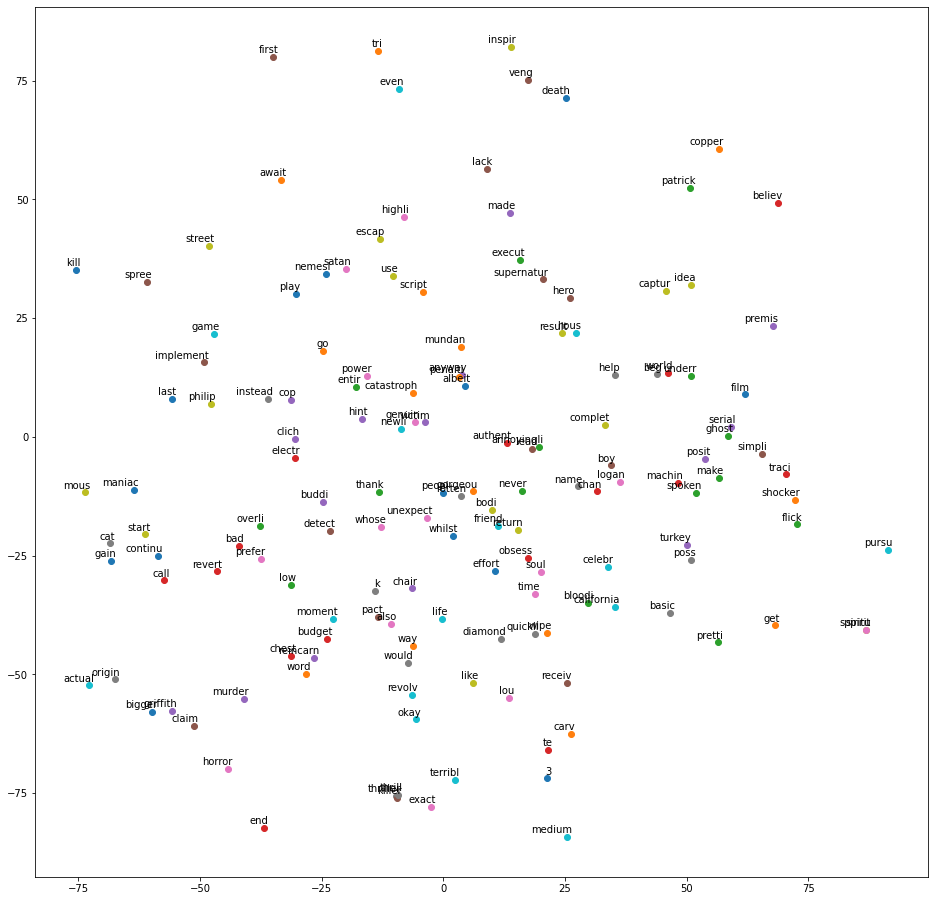

In [ ]:
plot_embeddings(embeddings_cbow_2d, 150)

En la representación se puede observar que hay palabras que están cerca en cuanto a representación espacial, pero no se acercan en significado, posiblemente debido a que el modelo se ha entrenado con datos relativamente limitados y centrados en un único tema, y esas palabras están relacionadas en el corpus.

## 3. Redes Neuronales Convolucionales (CNN)

Una vez realizado el pre-procesamiento y representación de los datos, se puede empezar a pensar en un modelo apropiado para realizar la tarea de Clasificación. Las Redes Neuronales Convolucionales son arquitecturas basadas en la operación de convolución, utilizada para la el reconocimiento de patrones y características locales. 

Se probarán distintas arquitecturas dentro de la red, con variedad de capas e hiperparámetros, como número de capas convolucionales, número y tamaño de filtros etc. 

También se probará a entrenar el modelo con las 2 representaciones realizadas en el apartado anterior (TF-IDF y FastText), y a entrenarlo introduciendo los datos en un modelo con una capa de Embedding, para observar las diferencias. 

En primer lugar pasamos el vector de etiquetas a una matriz.

In [7]:
# Vector de etiquetas -> matriz de etiquetas
tensor_y_train = to_categorical(binary_y_train, num_classes=2)
tensor_y_test = to_categorical(binary_y_test, num_classes=2)
print("Vector de etiquetas: ", binary_y_train)
print("Matriz de etiquetas: \n", tensor_y_train)

Vector de etiquetas:  [0 1 0 ... 0 0 0]
Matriz de etiquetas: 
 [[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


Definimos las constantes para todas las CNN que vamos a entrenar.

In [8]:
from nltk.corpus.reader.knbc import test
# Número de épocas (iteraciones globales)
epochs = 40
# Tamaño de batch (lote)
batch_size = 64
#Máxima longitud del documento
max_len = 512

# Características de los datos
features = 100
classes = 2
train_samples = 8000
test_samples = 2000

num_batches_train = (int) (train_samples / batch_size)

La función `print_train_stats` muestra las estadísticas de entrenamiento (*accuraccy* y pérdida, de entrenamiento y validación) cada modelo entrendo con los parámetros dados.

In [ ]:
def print_train_stats(conv_layers, filter, kernel, padding, pool_size, history):
  print("Model with params: " + \
        "conv_layers:" + str(conv_layers) + \
        ", filter:" + str(filter) + \
        ", kernel:" + str(kernel) + \
        ", padding:" + str(padding) + \
        ", pool_size:" + str(pool_size) + \

        " with results: " + \
        "accuracy: " + str(round(history.history['accuracy'][-1], 3)) + \
        ", loss: " + str(round(history.history['loss'][-1], 3)) + \
        ", val accuracy: " + str(round(history.history['val_accuracy'][-1], 3))  + \
        ", val loss: " +  str(round(history.history['val_loss'][-1], 3))) 

La función `plot_loss_accuracy_training` muestra de forma gráfica el desarrollo de los valores de *accucary* y pérdida a lo largo de todas las *epoch* de entrenamiento.

In [ ]:
def plot_loss_accuracy_training(history):
  print(history.history.keys())
  
  fig = plt.figure(figsize = (6, 6))
  plt.xticks(fontsize=15)
  plt.yticks(fontsize=15)

  # Gráfica de la accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy', fontsize=20)
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  fig = plt.figure(figsize = (6, 6))
  plt.xticks(fontsize=15)
  plt.yticks(fontsize=15)
  
  # Gráfica de la pérdida
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss', fontsize=20)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

La función `create_cnn` crea una red convolucional básica, sólo con capas convolucionales, y los hiperparámetros dados.

In [ ]:
def create_cnn(conv_layers, filter, kernel, padding, pool_size):
    model = Sequential()
    model.add(Conv1D(filters=filter, kernel_size=kernel, strides=1, padding=padding, input_shape=(batch_size, features)))
    model.add(MaxPooling1D(pool_size=pool_size, strides=1, padding=padding))

    for _ in range(1, conv_layers):
      model.add(Conv1D(filters=filter, kernel_size=kernel, strides=1, padding=padding))
      model.add(MaxPooling1D(pool_size=pool_size, strides=1, padding=padding))

    model.add(Flatten())
    model.add(Dense(2))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

La función `train_best_cnn` crea una serie de modelos, con los hiperparámetros dados, seleccionando finalmente el modelo con mejor *accuracy* de validación.

Debido al tiempo tan largo de entrenamiento cuando el modelo tienen una capa de Embeddings, se han añadido dos condiciones de parada para el modelo (*early stopping*), para la *accuracy* y pérdida del conjunto de validación, con una paciencia de 5 (si la *accuracy* o la pérdida empeoran 5 *epoch* seguidas el modelo deja de entrenar.

In [ ]:
def train_best_cnn(X, y, params, is_embedding=False):
  max_acc = 0
  best = 0
  early_stopping_loss = EarlyStopping(monitor='val_loss', patience=5)
  early_stopping_acc = EarlyStopping(monitor='val_accuracy', patience=5)

  for conv_layers in params['conv_layers']:
    for filter in params['filter']:
      for kernel in params['kernel']:
          for padding in params['padding']:
            for pool_size in params['pool_size']:

                if (is_embedding):
                  conv_network = create_cnn_embedding(conv_layers=conv_layers, filter=filter, kernel=kernel, padding=padding, pool_size=pool_size)
                else:
                  conv_network = create_cnn(conv_layers=conv_layers, filter=filter, kernel=kernel, padding=padding, pool_size=pool_size)

                history = conv_network.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.2, workers=-1, verbose=0, callbacks=[early_stopping_loss, early_stopping_acc])
                current_acc = history.history['val_accuracy'][-1]
                if (current_acc > max_acc):
                  max_acc = current_acc
                  best = (conv_network, history)
                  print("NEW BEST!")
                  print_train_stats(conv_layers, filter, kernel, padding, pool_size, history)
  return best

La función `evaluate_nn_classifier` evalúa el modelo creado, con las métricas de precisión, *recall*, y *f1score*.

In [ ]:
def evaluate_nn_classifier(X, y, model):
  yhat = model.predict(X)
  yhat = np.argmax(yhat, axis=1)

  precision_ = precision_score(y, yhat)
  recall_ = recall_score(y, yhat)
  f1score_ = f1_score(y, yhat)

  print("Precision: %0.3f Recall %0.3f F1 score: %0.3f for %s" % (precision_, recall_, f1score_, "Neuronal Network"))

Se definen los hiperparámetros que se han seleccionado para encontrar el mejor modelo base, y posteriormente ir probarndo distintas capas para tratar de mejorar los resultados del modelo base.

Debido al coste temporal de realizar los entrenamientos con las distintas combinaciones de parámetros, se han seleccionado un conjunto de parámetros que se consideran los más importantes:

*   Número de capas de convolución / *pooling*, se han decidido hacer de 1 a 4 capas convolucionales. Todas con los mismos hiperparámetros.
*   Número de filtros, de 16, 32 y 64, a tener en cuenta que este número será el número de características que el modelo pasará a la siguiente capa.
*   Tamaño del kernel o filtro, 3, 4 y 5.
*   *Padding*, aplicando un rellenado con ceros uniformemente a la izquierda/derecha o arriba/abajo de la entrada, de manera que la salida tiene la misma dimensión de altura/ancho que la entrada (*same*) o sin *padding*.
*   Tamaño del *pool*, o ventana de *pooling*, de 2, 3 y 4.

Se seleccionó la operación de *pooling* de máximos, debido a que es la utilizada generalmente.

In [ ]:
params = dict(conv_layers=[1, 2, 3, 4], 
              filter=[16, 32, 64], 
              kernel=[3, 4, 5], 
              padding=['valid', 'same'],
              pool_size=[3, 4, 5])

early_stopping_loss = EarlyStopping(monitor='val_loss', patience=4)
early_stopping_acc = EarlyStopping(monitor='val_accuracy', patience=4)

### 3.1 CNN sin capa de Embedding 

En primer lugar, se probará a entrenar el modelo básico definido anteriormente, pasando como entara los datos representados mediante TF-IDF y *word embeddings*, probando todos los parámetros definidos anteriormente.


**TF-IDF**

Primero se probó a introducir los datos representados mediante TF-IDF, este apartado dio varios problemas debido a que la capa convolucional requiere como entrada una matriz de 3 dimensiones de la forma: `batch_shape + (steps, input_dim)` por lo que fue complicado encontrar la manera de introducir los datos de esta forma, por ello se modificaron las dimensiones de los vectores de entrenamiento, para que se adaptase al tamaño del batch.

In [ ]:
tfidf_x_train_reshaped = tfidf_x_train.reshape(num_batches_train, batch_size, features)
print(tfidf_x_train_reshaped.shape)

(125, 64, 100)


Después se entrenaron los modelos con los parámetros especificados anteriormente.

NEW BEST!
Model with params: conv_layers:1, filter:16, kernel:3, padding:valid, pool_size:3 with results: accuracy: 0.6, loss: 3.655, val accuracy: 0.44, val loss: 4.743
NEW BEST!
Model with params: conv_layers:1, filter:16, kernel:3, padding:valid, pool_size:5 with results: accuracy: 0.64, loss: 0.693, val accuracy: 0.52, val loss: 0.715
NEW BEST!
Model with params: conv_layers:1, filter:16, kernel:4, padding:valid, pool_size:3 with results: accuracy: 0.4, loss: 4.98, val accuracy: 0.56, val loss: 3.868
NEW BEST!
Model with params: conv_layers:1, filter:16, kernel:4, padding:valid, pool_size:4 with results: accuracy: 0.48, loss: 0.867, val accuracy: 0.6, val loss: 0.799
NEW BEST!
Model with params: conv_layers:3, filter:32, kernel:4, padding:same, pool_size:3 with results: accuracy: 0.54, loss: 0.735, val accuracy: 0.64, val loss: 0.716
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


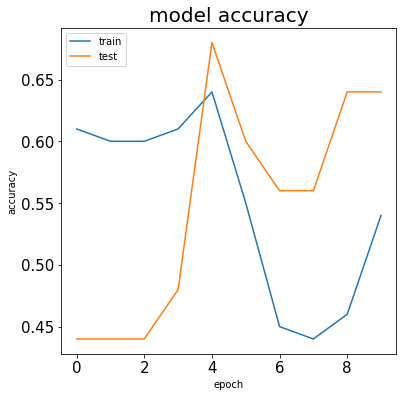

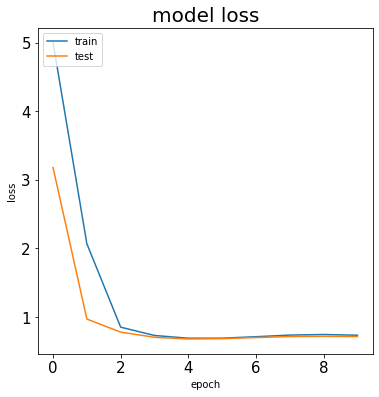

In [ ]:
(conv_net_tfidf, history_tfidf) = train_best_cnn(tfidf_x_train_reshaped, tensor_y_train, params)
plot_loss_accuracy_training(history_tfidf)

Tal y como se esperaba, los resultados no son demasiado buenos, con un accuracy máximo de 64%. Posiblemente debido a que la representación no es demasiado significativa para la convolución, ya que da información de frecuencias, y no semántica o contextual, como es el caso de los *word embeddings*.

**FastText**

En segundo lugar, se realizará la prueba introduciendo los *embeddings* previamente entrenados en el modelo de FastText. Se debe realizar el mismo paso que en el caso anterior, adaptar la matriz de dos dimensiones a las 3 dimensiones que necesita la capa de convolución, que en este caso será de entrada.

In [46]:
tensor_x_train = X_train['review_vectors'].values
tensor_x_train = np.concatenate(tensor_x_train).reshape(8000, 100)

tensor_x_test = X_test['review_vectors'].values
tensor_x_test = np.concatenate(tensor_x_test).reshape(2000, 100)

tensor_x_train_reshaped = tensor_x_train.reshape(num_batches_train, batch_size, features)
print(tensor_x_train_reshaped.shape)

(125, 64, 100)


A continuación se buscan los mejores hiperparámetros para el modelo con *word embeddings*.

NEW BEST!
Model with params: conv_layers:1, filter:16, kernel:3, padding:valid, pool_size:3 with results: accuracy: 0.6, loss: 1.702, val accuracy: 0.44, val loss: 1.645
NEW BEST!
Model with params: conv_layers:1, filter:16, kernel:3, padding:same, pool_size:4 with results: accuracy: 0.4, loss: 1.657, val accuracy: 0.56, val loss: 1.526
NEW BEST!
Model with params: conv_layers:3, filter:32, kernel:5, padding:same, pool_size:5 with results: accuracy: 0.45, loss: 7.712, val accuracy: 0.6, val loss: 7.712
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


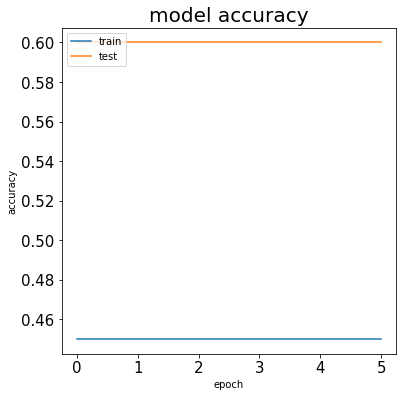

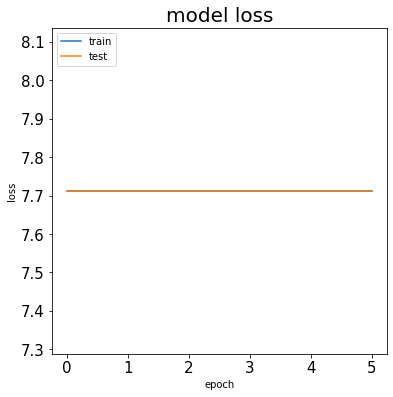

In [ ]:
(conv_net_w2v, history_w2v) = train_best_cnn(tensor_x_train_reshaped, tensor_y_train, params)
plot_loss_accuracy_training(history_w2v)

Tal y como se observa, los valores de *loss* y *accuracy* se mantienen constantes durante las 5 *epoch* que dura el entrenamiento. Esto puede ser debido a que el optimizador no es el adecuado para los datos de entrada. La mejor *accuracy* obtenida es peor a la anterior, un 60%.

### 3.2 CNN con capa de Embedding 

Tras comprobar que los resultados de utilizar la capa convolucional de capa de entrada e introducir los datos no ha resultado del todo efectivo (máxima *accuracy* obtenida del 64%), se va a proceder a introducir una primera capa de Embedding, a la cual se le pasarán los datos directamente, esperando que así se mejoren los resultados, debido a que no se necesita manipular las dimensiones como en los casos anteriores.

In [10]:
max_len = 512

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['review_processed'])

# Se transforman a secuencias numéricas (secuencia de palabras -> secuencia de números)
sequences_train = tokenizer.texts_to_sequences(X_train['review_processed'])
sequences_test = tokenizer.texts_to_sequences(X_test['review_processed'])

# Es necesario que ambas tengan la misma longitud
nn_x_train = pad_sequences(sequences_train, maxlen=max_len)
nn_x_test = pad_sequences(sequences_test, maxlen=max_len)

vocab_size = len(tokenizer.word_index) + 1
print(nn_x_train.shape)

(8000, 512)


La función `create_cnn_embedding`, similar a la anterior descrita, crea una CNN base, con los hiperparámetros dados, con una capa de Emebedding como capa de entrada.

In [ ]:
def create_cnn_embedding(conv_layers, filter, kernel, padding, pool_size):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=features, input_length=max_len))
    model.add(Conv1D(filters=filter, kernel_size=kernel, strides=1, padding=padding, input_shape=(max_len, features)))
    model.add(MaxPooling1D(pool_size=pool_size, strides=1, padding=padding))

    for _ in range(1, conv_layers):
      model.add(Conv1D(filters=filter, kernel_size=kernel, strides=1, padding=padding))
      model.add(MaxPooling1D(pool_size=pool_size, strides=1, padding=padding))

    model.add(Flatten())
    model.add(Dense(2))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

En esta ocasión reducimos el número de parámetros debido a que cada modelo tarda mucho más en entrenarse debido a la capa de Emebedding, la ejecución de todos modelos con los siguientes hiperparámetros se alargó hasta 8 horas.

NEW BEST!
Model with params: conv_layers:1, filter:16, kernel:3, padding:valid, pool_size:3 with results: accuracy: 1.0, loss: 0.006, val accuracy: 0.827, val loss: 0.819
NEW BEST!
Model with params: conv_layers:1, filter:16, kernel:3, padding:valid, pool_size:4 with results: accuracy: 0.999, loss: 0.017, val accuracy: 0.848, val loss: 0.902
NEW BEST!
Model with params: conv_layers:1, filter:16, kernel:3, padding:valid, pool_size:5 with results: accuracy: 1.0, loss: 0.003, val accuracy: 0.849, val loss: 0.658
NEW BEST!
Model with params: conv_layers:1, filter:16, kernel:4, padding:same, pool_size:5 with results: accuracy: 0.999, loss: 0.015, val accuracy: 0.852, val loss: 0.647
NEW BEST!
Model with params: conv_layers:1, filter:32, kernel:3, padding:same, pool_size:4 with results: accuracy: 1.0, loss: 0.007, val accuracy: 0.865, val loss: 0.568
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


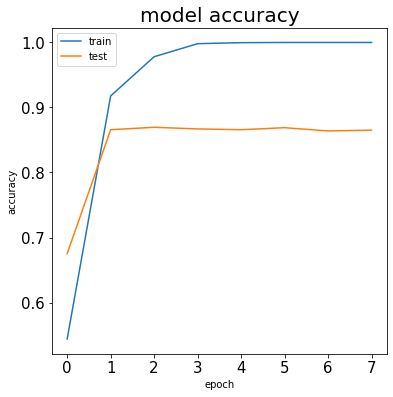

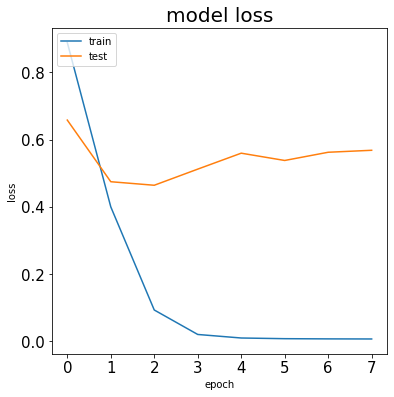

In [ ]:
params = dict(conv_layers=[1, 2, 3], 
              filter=[16, 32, 64], 
              kernel=[3, 4, 5], 
              padding=['valid', 'same'],
              pool_size=[3, 4, 5])
 
(conv_net_emb, history_emb) = train_best_cnn(nn_x_train, tensor_y_train, params, is_emWbedding=True)
plot_loss_accuracy_training(history_emb)

Tal y como se observa, el mejor modelo según el criterio de la *accuracy* de validación es el modelo con 1 sola capa de convolución y *pooling*, con 32 filtros de tamaño 3, con *padding*, y con una ventana de *pooling* de 4.

Este modelo lo utilizaremos como base, y vamos a tratar de mejorar sus resultados añadiendo varias capas y modificando sus parámetros.

In [ ]:
base_model = create_cnn_embedding(conv_layers=1, filter=32, kernel=3, padding='same', pool_size=4)
base_model.fit(nn_x_train, tensor_y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, workers=-1, verbose=1, callbacks=[early_stopping_loss, early_stopping_acc])
print("\nBaseline model: ")
evaluate_nn_classifier(nn_x_test, binary_y_test, base_model)

Epoch 1/40
100/100 [==============================] - 25s 235ms/step - loss: 0.8473 - accuracy: 0.5217 - val_loss: 0.6761 - val_accuracy: 0.5775
Epoch 2/40
100/100 [==============================] - 19s 187ms/step - loss: 0.4602 - accuracy: 0.8925 - val_loss: 0.4141 - val_accuracy: 0.8462
Epoch 3/40
100/100 [==============================] - 15s 152ms/step - loss: 0.1206 - accuracy: 0.9714 - val_loss: 0.4674 - val_accuracy: 0.8537
Epoch 4/40
100/100 [==============================] - 15s 155ms/step - loss: 0.0276 - accuracy: 0.9962 - val_loss: 0.5737 - val_accuracy: 0.8644
Epoch 5/40
100/100 [==============================] - 16s 155ms/step - loss: 0.0112 - accuracy: 0.9992 - val_loss: 0.5920 - val_accuracy: 0.8606
Epoch 6/40
100/100 [==============================] - 15s 154ms/step - loss: 0.0064 - accuracy: 0.9995 - val_loss: 0.6587 - val_accuracy: 0.8544

Baseline model: 
Precision: 0.878 Recall 0.826 F1 score: 0.851 for Neuronal Network


El modelo base tiene un *f1score* del 85.1%, vamos a utilizar esto como métrica para comparar los distintos modelos que se vayan a entrenar.

### 3.3 Distintas aproximaciones para mejorar el modelo base

A continuación se prueban distintas capas para tratar de mejorar los resultados del modelo base.

**3.3.1 Añadir una capa densa**

Como el modelo base solo tiene uan capa densa para la salida, se va a introducir otra capa oculta intermedia, con el número de unidades del número de filtros (32).

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=features, input_length=max_len))

model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', input_shape=(max_len, features)))
model.add(MaxPooling1D(pool_size=4, strides=1, padding='same'))

model.add(Flatten())
model.add(Dense(32))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 512, 100)          3218100   
                                                                 
 conv1d_2 (Conv1D)           (None, 512, 32)           9632      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 512, 32)          0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 16384)             0         
                                                                 
 dense_3 (Dense)             (None, 32)                524320    
                                                                 
 dense_4 (Dense)             (None, 2)                 66        
                                                      

In [ ]:
model.fit(nn_x_train, tensor_y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, workers=-1, verbose=1, callbacks=[early_stopping_loss, early_stopping_acc])
evaluate_nn_classifier(nn_x_test, binary_y_test, model)

Epoch 1/40
100/100 [==============================] - 14s 140ms/step - loss: 0.5733 - accuracy: 0.6747 - val_loss: 0.3493 - val_accuracy: 0.8487
Epoch 2/40
100/100 [==============================] - 13s 134ms/step - loss: 0.1472 - accuracy: 0.9433 - val_loss: 0.3601 - val_accuracy: 0.8550
Epoch 3/40
100/100 [==============================] - 13s 132ms/step - loss: 0.0241 - accuracy: 0.9948 - val_loss: 0.4613 - val_accuracy: 0.8444
Epoch 4/40
100/100 [==============================] - 15s 151ms/step - loss: 0.0037 - accuracy: 0.9995 - val_loss: 0.5263 - val_accuracy: 0.8469
Epoch 5/40
100/100 [==============================] - 13s 132ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.5692 - val_accuracy: 0.8462
Precision: 0.859 Recall 0.867 F1 score: 0.863 for Neuronal Network


Al parecer los resultados son superiores al modelo base, con un *f1score* del 86.3%.

**3.3.2 Sustituir el *pooling* local por global**

Se ha sustituido la capa de Max Pooling, por una de Max Pooling Global, para ver si así mejoran los resultados, se suele utilizar esta capa al final de las capas de convolución, antes de las capas densas. Como la capa de GlobalMaxPooling1D tiene como salida una matriz de 2 dimensiones en lugar de 3, no es necesario utilizar la capa Flatten.

Se ha probado a utilizar la capa GlobalMaxPooling1D manteniendo las dimensiones de entrada (keepdims = True), pero ha dado mejores resultados sin mantenerlas (opción por defecto).

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=features, input_length=max_len))

model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same'))
model.add(GlobalMaxPooling1D())

model.add(Dense(32))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 512, 100)          3218100   
                                                                 
 conv1d_32 (Conv1D)          (None, 512, 32)           9632      
                                                                 
 global_max_pooling1d_4 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_54 (Dense)            (None, 32)                1056      
                                                                 
 dense_55 (Dense)            (None, 2)                 66        
                                                                 
Total params: 3,228,854
Trainable params: 3,228,854
Non-trainable params: 0
___________________________________________

In [ ]:
model.fit(nn_x_train, tensor_y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, workers=-1, verbose=1, callbacks=[early_stopping_loss, early_stopping_acc])
evaluate_nn_classifier(nn_x_test, binary_y_test, model)

Epoch 1/40
100/100 [==============================] - 14s 134ms/step - loss: 0.6324 - accuracy: 0.6641 - val_loss: 0.4740 - val_accuracy: 0.7912
Epoch 2/40
100/100 [==============================] - 13s 130ms/step - loss: 0.3392 - accuracy: 0.8637 - val_loss: 0.3470 - val_accuracy: 0.8519
Epoch 3/40
100/100 [==============================] - 13s 131ms/step - loss: 0.1120 - accuracy: 0.9711 - val_loss: 0.3324 - val_accuracy: 0.8606
Epoch 4/40
100/100 [==============================] - 16s 162ms/step - loss: 0.0201 - accuracy: 0.9977 - val_loss: 0.3522 - val_accuracy: 0.8531
Epoch 5/40
100/100 [==============================] - 13s 132ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.3691 - val_accuracy: 0.8519
Epoch 6/40
100/100 [==============================] - 13s 133ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.3821 - val_accuracy: 0.8537
Epoch 7/40
100/100 [==============================] - 13s 132ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.3927 - val_ac

Al parecer no ha funcionado demasiado bien la capa de Global Pooling, con un *f1score* de 85.2%, tal vez debido a que hay una única capa de convolución.

**3.3.3 Añadir otra capa densa y capas de Dropout**

Se ha añadido otra capa densa, en este caso de 16 unidades, colocada entre la capa densa de 32 y la capa de salida. Añadiendo también una capa de Dropout para cada cada oculta, para tratar de evitar el sobre entrenamiento, ya que se trata de un corpus de datos pequeño. Se han probado varios valores de Dropout y el más satisfactorio parece ser el 20%.

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=features, input_length=max_len))

model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', input_shape=(max_len, features)))
model.add(MaxPooling1D(pool_size=4, strides=1, padding='same'))

model.add(Flatten())
model.add(Dense(32))
model.add(Dropout(0.2))
model.add(Dense(16))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 512, 100)          3218100   
                                                                 
 conv1d_33 (Conv1D)          (None, 512, 32)           9632      
                                                                 
 max_pooling1d_27 (MaxPoolin  (None, 512, 32)          0         
 g1D)                                                            
                                                                 
 flatten_26 (Flatten)        (None, 16384)             0         
                                                                 
 dense_56 (Dense)            (None, 32)                524320    
                                                                 
 dropout_16 (Dropout)        (None, 32)                0         
                                                     

In [ ]:
model.fit(nn_x_train, tensor_y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, workers=-1, verbose=1, callbacks=[early_stopping_loss, early_stopping_acc])
evaluate_nn_classifier(nn_x_test, binary_y_test, model)

Epoch 1/40
100/100 [==============================] - 16s 157ms/step - loss: 3.0835e-04 - accuracy: 1.0000 - val_loss: 0.6982 - val_accuracy: 0.8600
Epoch 2/40
100/100 [==============================] - 17s 165ms/step - loss: 2.1900e-04 - accuracy: 1.0000 - val_loss: 0.7299 - val_accuracy: 0.8619
Epoch 3/40
100/100 [==============================] - 16s 156ms/step - loss: 2.0491e-04 - accuracy: 1.0000 - val_loss: 0.7539 - val_accuracy: 0.8581
Epoch 4/40
100/100 [==============================] - 16s 156ms/step - loss: 1.6008e-04 - accuracy: 1.0000 - val_loss: 0.7802 - val_accuracy: 0.8575
Epoch 5/40
100/100 [==============================] - 16s 157ms/step - loss: 1.0354e-04 - accuracy: 1.0000 - val_loss: 0.7995 - val_accuracy: 0.8569
Precision: 0.853 Recall 0.877 F1 score: 0.865 for Neuronal Network


Los resultados obtenidos superan a los del modelo base, pero no al parecer añadir otra capa densa y capas de dropout no mejora significativamente el modelo, con un *f1score* del 86.5%.

A continuación se va a probar eliminando la capa de Dropout de la primer capa densa.

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=features, input_length=max_len))

model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', input_shape=(max_len, features)))
model.add(MaxPooling1D(pool_size=4, strides=1, padding='same'))

model.add(Flatten())
model.add(Dense(32))
model.add(Dense(16))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(nn_x_train, tensor_y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, workers=-1, verbose=1, callbacks=[early_stopping_loss, early_stopping_acc])
evaluate_nn_classifier(nn_x_test, binary_y_test, model)

Epoch 1/40
100/100 [==============================] - 20s 179ms/step - loss: 0.5841 - accuracy: 0.6720 - val_loss: 0.3463 - val_accuracy: 0.8525
Epoch 2/40
100/100 [==============================] - 16s 157ms/step - loss: 0.1788 - accuracy: 0.9341 - val_loss: 0.3472 - val_accuracy: 0.8531
Epoch 3/40
100/100 [==============================] - 16s 156ms/step - loss: 0.0219 - accuracy: 0.9945 - val_loss: 0.5000 - val_accuracy: 0.8550
Epoch 4/40
100/100 [==============================] - 16s 157ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.5839 - val_accuracy: 0.8531
Epoch 5/40
100/100 [==============================] - 16s 156ms/step - loss: 7.5820e-04 - accuracy: 1.0000 - val_loss: 0.6359 - val_accuracy: 0.8519
Precision: 0.860 Recall 0.876 F1 score: 0.868 for Neuronal Network


Al parecer los resultados son ligeramente superiores eliminando dejando solo la capa de dropout en la ultima capa, con un *f1score* del 86.8%, los mejores resultados obtenidos.

## 4. Visualización de las activaciones de la capa convolucional

En ocasiones es complicado analizar los resultados obtenidos mediante la capa convolucional, debido a que es complicado interpretarlos. Por ello, en este apartado se va a realizar un análisis del comportamiento de la capa de convolución.

Se va a crear un modelo sencillo, que tenga una capa de entrada y de salida, y una capa de convolución y de *pooling*, únicamente con 20 filtros y un kernel de 3 palabras. Tras ello se entrenará y posteriormente se le pasarán frases de prueba, y se analizará la activación de los filtros para cada kernel.

In [67]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=features, input_length=max_len))

model.add(Conv1D(filters=20, kernel_size=3, input_shape=(max_len, features), activation='relu'))
model.add(MaxPooling1D(pool_size=3))

model.add(Flatten())
model.add(Dense(2, activation='softmax'))
print(model.summary())
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 512, 100)          3218100   
                                                                 
 conv1d_1 (Conv1D)           (None, 510, 20)           6020      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 170, 20)          0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 3400)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 6802      
                                                                 
Total params: 3,230,922
Trainable params: 3,230,922
Non-trainable params: 0
____________________________________________

Entrenamiento del modelo.

In [68]:
early_stopping_loss = EarlyStopping(monitor='val_loss', patience=4)
model.fit(nn_x_train, tensor_y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, workers=-1, verbose=1, callbacks=[early_stopping_loss])

Epoch 1/40
100/100 [==============================] - 14s 132ms/step - loss: 0.6820 - accuracy: 0.6209 - val_loss: 0.6065 - val_accuracy: 0.7994
Epoch 2/40
100/100 [==============================] - 13s 131ms/step - loss: 0.3258 - accuracy: 0.8867 - val_loss: 0.2986 - val_accuracy: 0.8788
Epoch 3/40
100/100 [==============================] - 13s 133ms/step - loss: 0.0872 - accuracy: 0.9750 - val_loss: 0.3334 - val_accuracy: 0.8681
Epoch 4/40
100/100 [==============================] - 13s 132ms/step - loss: 0.0277 - accuracy: 0.9948 - val_loss: 0.3991 - val_accuracy: 0.8637
Epoch 5/40
100/100 [==============================] - 13s 133ms/step - loss: 0.0096 - accuracy: 0.9987 - val_loss: 0.4422 - val_accuracy: 0.8612
Epoch 6/40
100/100 [==============================] - 13s 132ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.4730 - val_accuracy: 0.8587


La función `plot` mostrará la activación de cada filtro.

In [69]:
def plot(df):
    # df = df[df['filter'] <= 10]
    df_wide = df.pivot("trigram", "filter", "activation")
    sns.set(rc = {'figure.figsize':(15, 8)})
    plt.xticks(rotation=75)
    sns.lineplot(data=df_wide)

La función `plot_filters_activations` crea un DataFrame a partir de la matriz de activaciones, donde cada activación del trigrama será la media de las activaciones de cada una de las palabras que lo componen, para ese filtro.

In [71]:
import statistics

def plot_filters_activations(conv_activations, tokens):
    df_main = pd.DataFrame()
    for word in range(conv_activations.shape[0] - 2):
        for filter in range(conv_activations.shape[-1]):
          activation = statistics.mean([conv_activations[word, -1:, filter][0], 
                                        conv_activations[word + 1, -1:, filter][0], 
                                        conv_activations[word + 2, -1:, filter][0]])
          values = {'trigram': tokens[word] + " " 
                    + tokens[word + 1] + " "
                    + tokens[word + 2], 
                    'filter': filter, 
                    'activation': activation}
          df = pd.DataFrame([values])
          df_main = df_main.append(df)
    plot(df_main)

La función `get_convolution_activations` preprocesa la frase de prueba, para posteriormente realizar una predicción sobre su sentimiento, y seleccionar la matriz de salida de la capa de convolución, para su posterior análisis.

In [72]:
def get_convolution_activations(sentence_test):
    tokens = process_text(sentence_test)

    # Se transforman a secuencias numéricas (secuencia de palabras -> secuencia de números)
    sequences_train = tokenizer.texts_to_sequences(tokens)

    # Es necesario que ambas tengan la misma longitud
    coded_sentence = pad_sequences(sequences_train, maxlen=max_len)

    layer_outputs = [layer.output for layer in model.layers]
    activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
    activations = activation_model.predict(coded_sentence)
    conv_activations = activations[1]
    conv_activations.shape #(word, new_steps, filters)
    return conv_activations, tokens

### 4.1 Primera frase de prueba

Vamos a realizar una primera prueba con la frase utilizada en el enunciado de la práctica para poder observar los resultados y compararlos con los del enunciado. En este caso se muestran todos los filtros.

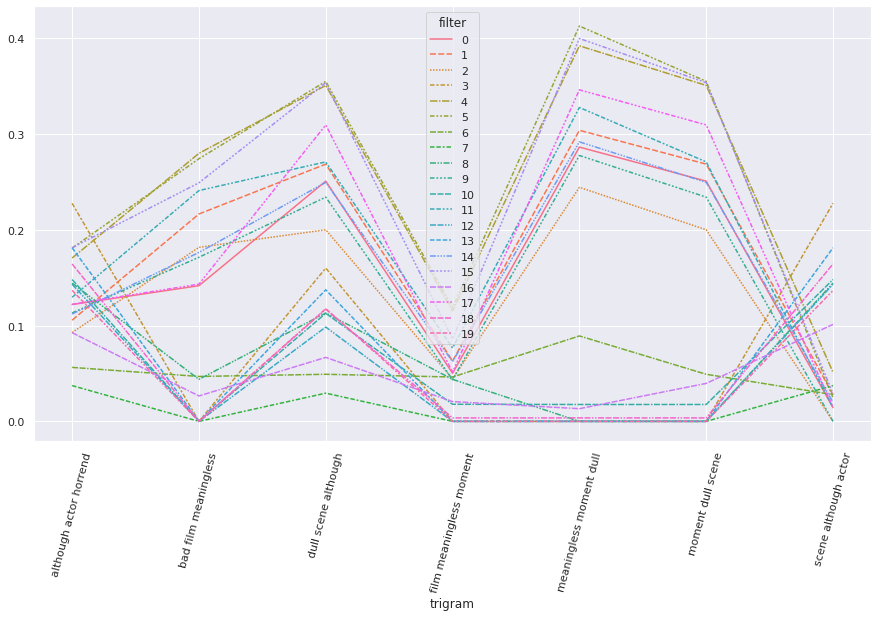

In [80]:
sentence_test = 'This is a very bad film with meaningless moments and dull scenes, although the actors are not horrendous'
conv_activations, tokens = get_convolution_activations(sentence_test)
plot_filters_activations(conv_activations, tokens)

Se puede observar que los trigramas "dull scene although", "meaningless moment dull" y "moment dull scene" han sido los que han producido una mayor activación a nivel general. Posiblemente debido a las palabras como "bad" o "dull". 

Las palabras como "film" parece no tener importancia, a lo ser de estar acompañadas por palabras importantes como "bad". Lo cual tiene sentido, ya que la palabra "film" puede estar representada en reviews positivas y negativas por igual, y "bad" y "dull" con adjetivos negativos. Sorprendentemente "horrend" no ha sido una palabra que haya activado los filtros, al menos acompañada de "actor".

También se puede ver que hay filtros vagamente activados, como el 6 y el 7.

### 4.2 Segunda frase de prueba

En esta segunda prueba, vamos a reorganizar la frase anterior, para tratar de ver si las palabras que forman el trigrama influyen o no en el resultado de la activación, probaremos a variar palabras como "dull", "horrend" y "bad". 

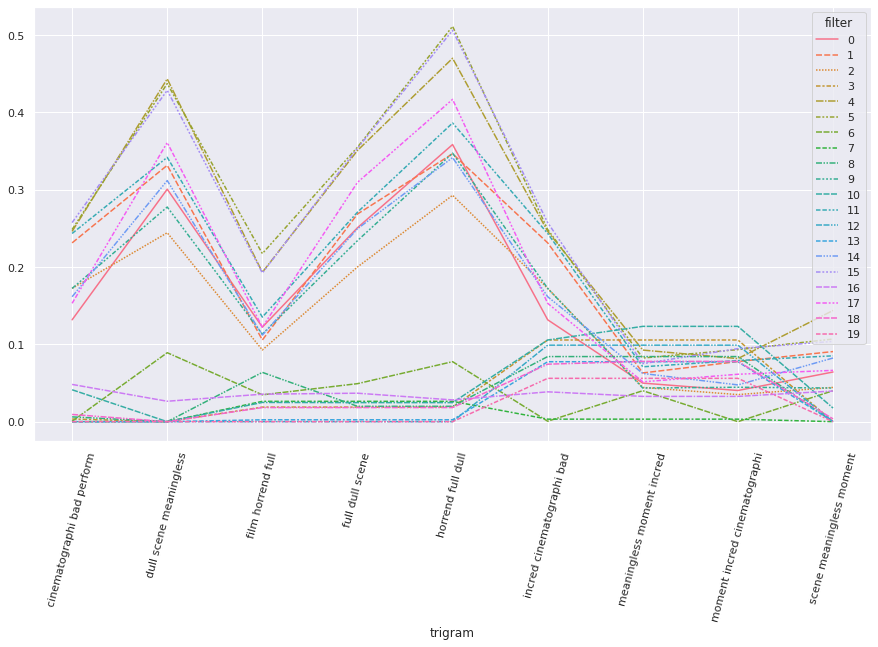

In [78]:
sentence_test = 'The film is horrendous, and full of dull scenes, meaningless moments, with incredible cinematography but bad performances'
conv_activations, tokens = get_convolution_activations(sentence_test)
plot_filters_activations(conv_activations, tokens)

Para este ejemplo, los trigramas con mayor activación son "dull scene meaningless" y "horrend full dull", lo que confirma que la palabra "dull" tiene un gran valor de activación en cualquier trigrama, ya que incluso el trigrama "full dull scene" activa también los filtros. En este caso la palabra "bad" también ha tenido cierta activación, sobre todo en el trigrama "cinematographi bad perform".

La palabra "horrend" parece presentar activación solo acompañada de "dull", donde ambas palabras formando un trigrama presentan la mayor activación, sin embargo, el trigrama "film horrend full" no presenta activación.

Lo cual parece significar que el contexto de las palabras, es decir, las palabras con las cuales se forma el trigrama, afectan a la activación del conjunto, pero también afecta el valor individual, como en el caso de "dull".

Se observa también, que trigramas como "meaningless moment incred", "moment incred cinematographi" o "scene meaningless moment" no parecen tener demasiada activación, posiblemente debido a la que la palabra "meaningless" o "incred" no han sido muy significativas en el corpus, por lo que no son discriminantorias para el análisis de sentimientos.

### 4.3 Tercera frase de prueba

En este ejemplo se va a probar con una frase inventada, sin realción con las anteriores, para valorar como influe la activación en otras palabras.

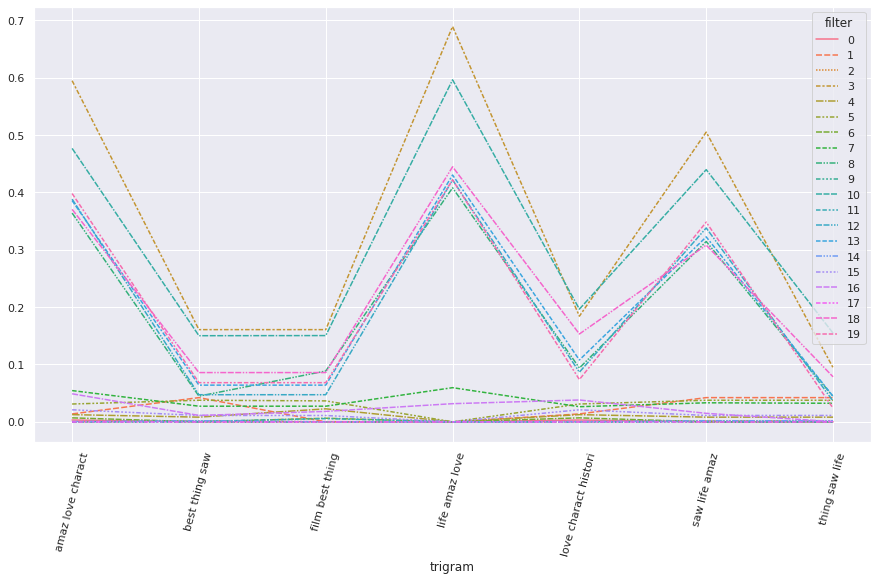

In [79]:
sentence_test = 'That film is the best thing I saw in my life, how amazing it is, I loved the characters and his history'
conv_activations, tokens = get_convolution_activations(sentence_test)
plot_filters_activations(conv_activations, tokens)

En este ejemplo se puede visualizar claramente que los trigramas "amaz love charact", "life amaz love" y "saw life amaz" son los que han tenido mayor activación, posiblemente por las palabras "amaz" y "love", donde la combinación de ambas produce los máximos valores. 

Por el contrario, los trigramas "best thing saw", "film best thing" y "thing saw life" parecen no tener activación, debido a la poca carga de sentimiento de las palabras, a excepción de la palabra "best".

Como en los ejemplos anteriores, parece no haber activación en los filtros numerosos filtros.

## 5. Conclusiones

Como conclusión del trabajo, puedo decir que he aprendido bastante el funcionamiento interno de las CNN, especialmente la capa de convolución durante el desarrollo y la visualización de los modelos. 

Se puede observar que es mucho más interesante utilizar una capa de embedding antes de la capa de convolución, en lugar de realizar una previa representación de los datos (tf-idf o FastText), y que los parámetros de la red, cambian su rendimiento, pero tampoco se han observado grandes cambios. Al observar las activaciones de la capa de convolución con los ejemplos, se pueder ver como las palabras que tienen mayor carga semántica de sentimientos positivos / negativos han producido una mayor activación, y no tanto las palabras con mejor significado, o muy repetidas en ambas clases, como 'film', lo cual resulta muy interesante.

Como dificultad cabe destacar que la entrada de datos de la capa de convolución es de 3 dimensiones en vez de 2, como los datos de entrada originales, por lo que ha sido complicado conseguir la forma de poder introducirlos.